In [18]:
!pip install --quiet numpy pandas scikit-learn matplotlib pyarrow

In [19]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import RepeatedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, ElasticNetCV, Lasso, LassoCV, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.mixture import GaussianMixture

RANDOM_STATE = 42
TOP_K = 25           # number of top features to display
STAB_B = 200         # bootstrap rounds for stability selection
STAB_SUBSAMPLE = 0.7 # fraction of rows per bootstrap
STAB_TAU = 0.6       # selection-frequency threshold for "signal"

# Paths
DATA_PATH_PARQUET = Path("/Users/cw/MATH 533 - Final Project/data/processed/riboflavin.parquet")
FIG_DIR  = Path("/Users/cw/MATH 533 - Final Project/results/Section1.2"); FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR  = Path("/Users/cw/MATH 533 - Final Project/results/Section1.2");  TAB_DIR.mkdir(parents=True, exist_ok=True)

In [22]:
# Load processed data
if DATA_PATH_PARQUET.exists():
    df = pd.read_parquet(DATA_PATH_PARQUET)
else:
    raise FileNotFoundError("No processed dataset found. Run 01_download_prepare.ipynb first.")

# Split X, y
y = df["target"].values
X = df.drop(columns=["target"]).values
feature_names = df.drop(columns=["target"]).columns.astype(str).to_numpy()

X.shape, y.shape

((71, 4088), (71,))

In [24]:
# Improved stability selection: Elastic Net + random feature weights
rng = np.random.RandomState(RANDOM_STATE)
sel_counts = np.zeros(X.shape[1], dtype=int)

# You can tweak these if you want
alpha = 0.05        # overall regularization strength
l1_ratio = 0.5      # 0.5 L1 + 0.5 L2 (good for correlated genes)

for b in range(STAB_B):
    # Subsample rows
    idx = rng.choice(len(y), int(STAB_SUBSAMPLE * len(y)), replace=False)
    scaler = StandardScaler(with_mean=True)
    Xb = scaler.fit_transform(X[idx])
    yb = y[idx]

    # Random feature weights (randomized Enet -> more robust selection)
    weights = rng.uniform(0.8, 1.2, size=Xb.shape[1])
    Xb_weighted = Xb * weights

    en = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=8000,
                    random_state=rng.randint(1e9))
    en.fit(Xb_weighted, yb)

    sel_counts += (np.abs(en.coef_) > 1e-12)

# Selection frequencies
sel_freq = sel_counts / STAB_B

# Features that are frequently selected
consensus_mask = sel_freq >= STAB_TAU
consensus_idx = np.where(consensus_mask)[0]

# Keep top-K features by selection frequency
if len(consensus_idx):
    order = np.argsort(sel_freq[consensus_idx])[::-1]
    feat_order = consensus_idx[order][:TOP_K]
else:
    order = np.array([], dtype=int)
    feat_order = np.array([], dtype=int)

print(f"Consensus features (≥{STAB_TAU:.0%} of bootstraps): {len(consensus_idx)}; displaying {len(feat_order)}")

Consensus features (≥60% of bootstraps): 9; displaying 9


In [64]:
# Define models
# Ridge
ridge = make_pipeline(
    StandardScaler(with_mean=True),
    RidgeCV(alphas=np.logspace(-3, 6, 25))
)

# Elastic Net
enet = make_pipeline(
    StandardScaler(with_mean=True),
    ElasticNetCV(l1_ratio=[.1,.3,.5,.7,.9,.95,.99,1.0],
                 alphas= np.logspace(-3,1,40),
                 max_iter=8000,
                 cv=5,
                 random_state=RANDOM_STATE)
)

def fit_bayesian_lasso_standardized(X, y):
    """
    Tries bayesreg (true Bayesian Lasso).
    Since bayesreg is unavailable, falls back to LassoCV (not Bayesian) so the notebook still runs.
    Returns (label, intercept, beta) on the ORIGINAL scale.
    """
    # Standardize once for the Bayesian fit (bayesreg standardizes internally, but we keep a scaler for fallback mapping)
    scaler = StandardScaler(with_mean=True).fit(X)
    Xs = scaler.transform(X)

    try:
        from bayesreg import bayesreg
        m = bayesreg(Xs, y, model='gaussian', method='blasso',
                     nsamples=4000, burnin=2000, thin=2, seed=RANDOM_STATE)
        beta_std = m['beta'].mean(axis=0)
        intercept_std = float(m['mu'].mean())
        # Map back to original scale
        beta = beta_std / (scaler.scale_ + 1e-12)
        intercept = intercept_std - (scaler.mean_ * beta).sum()
        label = "Bayesian Lasso (bayesreg)"
    except Exception as e:
        # Fallback: deterministic LassoCV
        pipe = make_pipeline(StandardScaler(with_mean=True),
                             LassoCV(alphas=np.logspace(-6, -2, 80), max_iter=8000, cv=5, random_state=RANDOM_STATE))
        pipe.fit(X, y)
        sc, lasso = pipe[0], pipe[1]

        print("LassoCV alpha grid: min =", lasso.alphas_.min(),
          ", max =", lasso.alphas_.max())
        print("LassoCV chosen alpha (global model):", lasso.alpha_)
        
        beta = lasso.coef_ / (sc.scale_ + 1e-12)
        intercept = lasso.intercept_ - (sc.mean_ * beta).sum()
        label = "LassoCV"
    return label, intercept, beta

In [66]:
# Cross-validated performance & coefficient extraction (stable metrics)
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
scorers = {"rmse": "neg_root_mean_squared_error",  # built-in scorer
           "r2": "r2"}

def evaluate(est, name):
    # scores across all folds (no per-sample predictions)
    out = cross_validate(est, X, y, cv=cv, scoring=scorers, n_jobs=-1, return_estimator=False)
    rmse = -out["test_rmse"].mean()
    r2   =  out["test_r2"].mean()

    # fit once on the full data to extract coefficients for plotting
    est.fit(X, y)
    sc, base = est[0], est[1]
    beta = base.coef_ / (sc.scale_ + 1e-12)
    intercept = base.intercept_ - (sc.mean_ * beta).sum()
    sparsity = int(np.sum(np.abs(beta) > 1e-12))
    return {"Method": name, "RMSE (CV)": rmse, "R² (CV)": r2, "Sparsity (#≠0)": sparsity}, (intercept, beta)

rows, coefs = [], {}

# Ridge
r_row, (r_int, r_beta) = evaluate(ridge, "RidgeCV")
rows.append(r_row); coefs["RidgeCV"] = (r_int, r_beta)

print("RidgeCV chosen alpha:", ridge[1].alpha_)

# Elastic Net
e_row, (e_int, e_beta) = evaluate(enet, "ElasticNetCV")
rows.append(e_row); coefs["ElasticNetCV"] = (e_int, e_beta)

#print alpha
print("ElasticNetCV chosen alpha:", enet[1].alpha_)
print("ElasticNetCV chosen l1_ratio:", enet[1].l1_ratio_)

# "Bayesian Lasso" (or fallback)
blabel, bl_int, bl_beta = fit_bayesian_lasso_standardized(X, y)
# If it fell back to LassoCV, compute CV metrics too
if "LassoCV" in blabel:
    from sklearn.pipeline import make_pipeline
    from sklearn.linear_model import LassoCV
    lasso_pipe = make_pipeline(
        StandardScaler(with_mean=True),
        LassoCV(alphas=np.logspace(-6, -2, 80), max_iter=8000, cv=5, random_state=RANDOM_STATE)
    )
    out = cross_validate(lasso_pipe, X, y, cv=cv, scoring=scorers, n_jobs=-1)
    rows.append({
        "Method": blabel,
        "RMSE (CV)": -out["test_rmse"].mean(),
        "R² (CV)":   out["test_r2"].mean(),
        "Sparsity (#≠0)": int(np.sum(np.abs(bl_beta) > 1e-12))
    })
else:
    rows.append({
        "Method": blabel,
        "RMSE (CV)": np.nan,
        "R² (CV)":   np.nan,
        "Sparsity (#≠0)": int(np.sum(np.abs(bl_beta) > 1e-12))
    })
coefs[blabel] = (bl_int, bl_beta)

leader = pd.DataFrame(rows).sort_values(by=["RMSE (CV)"], na_position="last")
leader

RidgeCV chosen alpha: 421.6965034285823
ElasticNetCV chosen alpha: 0.18047217668271703
ElasticNetCV chosen l1_ratio: 0.1
LassoCV alpha grid: min = 1e-06 , max = 0.01
LassoCV chosen alpha (global model): 0.0031165269449294304


,Method,RMSE (CV),R² (CV),Sparsity (#≠0)
1,ElasticNetCV,0.492849,0.648890,158
0,RidgeCV,0.527197,0.610773,4088
2,LassoCV,0.586419,0.383435,69


In [68]:
# Save Leaderboard
leader_file = TAB_DIR / "leaderboard.csv"
leader.to_csv(leader_file, index=False)
leader_file.resolve()

PosixPath('/Users/cw/MATH 533 - Final Project/results/Section1.2/leaderboard.csv')

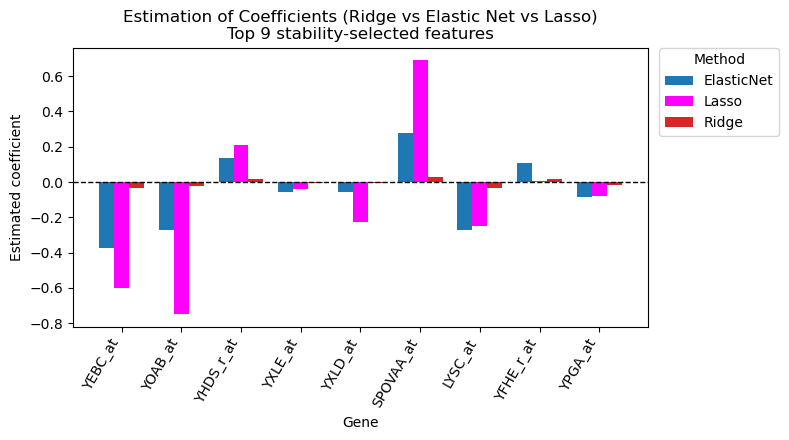

PosixPath('/Users/cw/MATH 533 - Final Project/results/Section1.2/ridge_enet_lasso_simulation_style.png')

In [70]:
# ----- Simulation-style bar plot: Ridge vs Elastic Net vs Lasso -----

# 1) Make sure we have a feature order (from stability selection or ENet fallback)
if len(feat_order) == 0:
    # If stability selection found no strong signals, fall back to top |beta| from ENet
    _, beta_ref = coefs["ElasticNetCV"]
    feat_order = np.argsort(np.abs(beta_ref))[::-1][:TOP_K]

K = len(feat_order)
x = np.arange(1, K + 1)        # covariate index 1..K
bar_width = 0.25

# Order + colors to mimic the textbook figure
model_order = ["ElasticNetCV", "LassoCV", "RidgeCV"]
colors = {"ElasticNetCV": "tab:blue",   # ENet = blue
          "LassoCV":      "magenta",    # Lasso = magenta
          "RidgeCV":      "tab:red"}    # Ridge = red

plt.figure(figsize=(8, 4.5))

for j, name in enumerate(model_order):
    if name not in coefs:
        continue  # if Bayesian Lasso didn't fall back to LassoCV
    _, beta = coefs[name]
    plt.bar(
        x + (j - (len(model_order) - 1) / 2) * bar_width,
        beta[feat_order],
        width=bar_width,
        color=colors[name],
        label=name.replace("CV", "")  # nicer legend labels
    )

# Dashed zero line
plt.axhline(0, color="black", linewidth=1.0, linestyle="--")

plt.xticks(x, feature_names[feat_order], rotation=60, ha="right")
plt.xlabel("Gene")
plt.ylabel("Estimated coefficient")
plt.title("Estimation of Coefficients (Ridge vs Elastic Net vs Lasso)\n"
          f"Top {K} stability-selected features")

plt.legend(
    title="Method",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.
)
plt.tight_layout()

fig_sim_path = FIG_DIR / "ridge_enet_lasso_simulation_style.png"
plt.savefig(fig_sim_path, dpi=160)
plt.show()
fig_sim_path.resolve()